# 查看FashionMNIST原始数据格式

In [15]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model

from torchvision.models import resnet50

from torchviz import make_dot


In [16]:
# 初始化ResNet50模型
model = resnet50(pretrained=True)

# 初始化ResNet50模型
model = resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

# 打印模型结构
print("ResNet50模型结构:")
print(model)

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数数量: {total_params}")

# 绘制模型结构图
try:

    
    # 创建一个随机输入
    x = torch.randn(1, 3, 224, 224)
    y = model(x)
    
    # 生成模型结构图
    dot = make_dot(y, params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render("resnet50_model_structure", cleanup=True)
    print("模型结构图已保存为 'resnet50_model_structure.png'")
except ImportError:
    print("请安装torchviz包以绘制模型结构图: pip install torchviz")
    
    # 使用matplotlib绘制简化的模型结构
    plt.figure(figsize=(10, 12))
    layers = ['conv1', 'bn1', 'relu', 'maxpool', 
              'layer1 (3块)', 'layer2 (4块)', 'layer3 (6块)', 'layer4 (3块)', 
              'avgpool', 'fc']
    layer_sizes = [64, 64, 64, 64, 256, 512, 1024, 2048, 2048, 1000]
    
    plt.barh(layers, layer_sizes, color='skyblue')
    plt.xlabel('特征维度')
    plt.title('ResNet50模型结构简图')
    plt.tight_layout()
    plt.show()


ResNet50模型结构:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

# 加载数据并处理为tensor

In [17]:
from pathlib import Path

DATA_DIR = Path("./archive/")

# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用ImageFolder加载数据
# ImageFolder假设数据集按照如下方式组织：root/class/image.jpg
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'training',
    transform=data_transforms['training']
)

test_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 128, 128]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [ ]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: #img是图像，_是标签
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

(tensor([ 1.5299e-04,  3.6267e-05, -6.5391e-07]),
 tensor([0.9999, 0.9999, 1.0002]))

# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [19]:


# 创建数据加载器
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


In [20]:
64*860

55040

# 搭建模型

In [21]:

#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


# 模型每一层是有名字的

In [22]:
count = 0
for name, param in model.named_parameters():
    print(name, param)
    count += 1
    if count >= 2:
        break

conv1.weight Parameter containing:
tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
           -2.0325e-02,  8.8140e-03],
          [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
            2.9346e-02, -5.8331e-02],
          [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
            2.1868e-01, -7.2909e-02],
          ...,
          [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
           -5.7855e-01,  2.2461e-01],
          [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
           -4.9317e-02, -6.8082e-02],
          [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
            1.8976e-01, -2.2302e-02]],

         [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
           -6.5541e-02,  1.6895e-02],
          [-3.3543e-02,  3.9067e-02,  8.6565e-02,  ...,  1.1713e-01,
            2.1848e-02, -4.4082e-02],
          [ 5.5285e-02, -2.6424e-01,  4.2687e-01,  ..., -2.3723e-01,
            3.2017e-01,

In [23]:
for i in model.children():
    print(i)
    break

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [24]:
import torch.nn as nn
import torchvision.models as models

class MonkeyResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 加载预训练的ResNet50模型
        self.resnet = models.resnet50(weights='IMAGENET1K_V2')
        
        # 冻结所有层的参数
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        for name, param in self.resnet.named_parameters():
            if name == "layer4.2.conv3.weight":#这一层解冻
                param.requires_grad = True 

        # 替换最后的全连接层
        # ResNet50的最后一层fc的输入特征是2048
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)
    
    # def unfreeze_layers(self, num_layers=0):
    #     """解冻最后几层进行微调"""
    #     if num_layers > 0:
    #         # 解冻最后的几个层
    #         layers_to_unfreeze = list(self.resnet.children())[-num_layers:]
    #         print(layers_to_unfreeze)
    #         for layer in layers_to_unfreeze:
    #             for param in layer.parameters():
    #                 param.requires_grad = True
    
                    
    def unfreeze_all(self):
        """解冻所有层"""
        for param in self.resnet.parameters():
            param.requires_grad = True


In [25]:
# 实例化模型
model = MonkeyResNet50()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)
    

print(outputs.shape)

批次图像形状: torch.Size([32, 3, 128, 128])
批次标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


In [29]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 1069066
模型总参数量: 23528522

各层参数量明细:
resnet.conv1.weight: 9408 参数
resnet.bn1.weight: 64 参数
resnet.bn1.bias: 64 参数
resnet.layer1.0.conv1.weight: 4096 参数
resnet.layer1.0.bn1.weight: 64 参数
resnet.layer1.0.bn1.bias: 64 参数
resnet.layer1.0.conv2.weight: 36864 参数
resnet.layer1.0.bn2.weight: 64 参数
resnet.layer1.0.bn2.bias: 64 参数
resnet.layer1.0.conv3.weight: 16384 参数
resnet.layer1.0.bn3.weight: 256 参数
resnet.layer1.0.bn3.bias: 256 参数
resnet.layer1.0.downsample.0.weight: 16384 参数
resnet.layer1.0.downsample.1.weight: 256 参数
resnet.layer1.0.downsample.1.bias: 256 参数
resnet.layer1.1.conv1.weight: 16384 参数
resnet.layer1.1.bn1.weight: 64 参数
resnet.layer1.1.bn1.bias: 64 参数
resnet.layer1.1.conv2.weight: 36864 参数
resnet.layer1.1.bn2.weight: 64 参数
resnet.layer1.1.bn2.bias: 64 参数
resnet.layer1.1.conv3.weight: 16384 参数
resnet.layer1.1.bn3.weight: 256 参数
resnet.layer1.1.bn3.bias: 256 参数
resnet.layer1.2.conv1.weight: 16384 参数
resnet.layer1.2.bn1.weight: 64 参数
resnet.layer1.2.bn1.bias: 64 参数
resnet

# 设置交叉熵损失函数，SGD优化器

In [31]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)


损失函数: CrossEntropyLoss()


In [32]:
model = MonkeyResNet50()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=10, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50,early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None,eval_step=50)


使用设备: cpu
训练开始，共1750步


  0%|          | 0/1750 [00:00<?, ?it/s]

In [ ]:
history['train'][-100:-1]

[{'loss': 0.0244493056088686, 'acc': 100.0, 'step': 1601},
 {'loss': 0.015628209337592125, 'acc': 100.0, 'step': 1602},
 {'loss': 0.0302165225148201, 'acc': 100.0, 'step': 1603},
 {'loss': 0.028941577300429344, 'acc': 100.0, 'step': 1604},
 {'loss': 0.03200396150350571, 'acc': 100.0, 'step': 1605},
 {'loss': 0.014572709798812866, 'acc': 100.0, 'step': 1606},
 {'loss': 0.021114032715559006, 'acc': 100.0, 'step': 1607},
 {'loss': 0.020425351336598396, 'acc': 100.0, 'step': 1608},
 {'loss': 0.01535417977720499, 'acc': 100.0, 'step': 1609},
 {'loss': 0.01704162359237671, 'acc': 100.0, 'step': 1610},
 {'loss': 0.014250325970351696, 'acc': 100.0, 'step': 1611},
 {'loss': 0.01552823930978775, 'acc': 100.0, 'step': 1612},
 {'loss': 0.02124432846903801, 'acc': 100.0, 'step': 1613},
 {'loss': 0.017624514177441597, 'acc': 100.0, 'step': 1614},
 {'loss': 0.023377973586320877, 'acc': 100.0, 'step': 1615},
 {'loss': 0.026866529136896133, 'acc': 100.0, 'step': 1616},
 {'loss': 0.02314138226211071, 'a

# 绘制损失曲线和准确率曲线

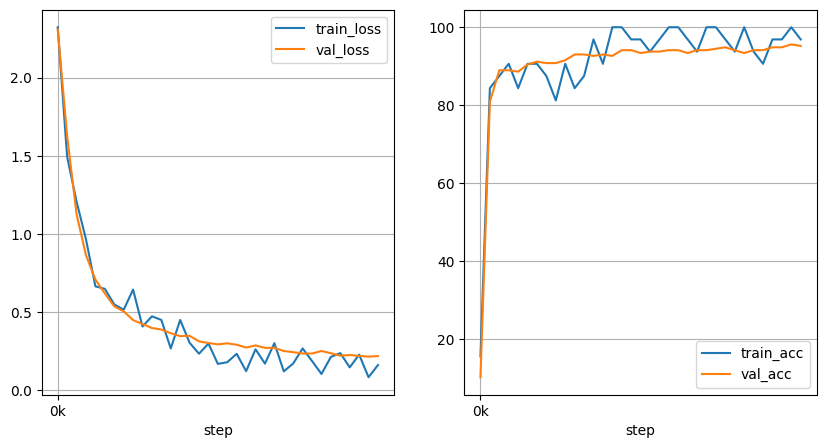

In [35]:
plot_learning_curves(history, sample_step=50)  #横坐标是 steps

In [34]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(95.22058823529412, 0.23589257720638723)